<a href="https://colab.research.google.com/github/Michaelyzr/coursework_cluster/blob/main/FundingRates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Funding Rate Strategies**

Import Data

In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import os
import numpy as np

In [ ]:
def transform(file_name:str):
  csv = pd.read_csv(file_name + '.csv')
  csv = csv[['Time', 'Annualized']]
  csv['Time'] = pd.to_datetime(csv['Time']).dt.date
  csv['Annualized'] = pd.to_numeric(csv['Annualized'])
  csv.rename(columns={'Annualized' : file_name + "_Annaulized"}, inplace=True)
  csv = csv[csv['Time'] > datetime.date(2023,1,28)]
  csv = csv.set_index('Time')
  return csv.groupby(by='Time').mean()

Visualization of Return

,BTC,SOL,ETH,FIL
BTC,1.000000,0.305257,0.719466,0.167393
SOL,0.305257,1.000000,0.337877,0.349203
ETH,0.719466,0.337877,1.000000,0.245728
FIL,0.167393,0.349203,0.245728,1.000000


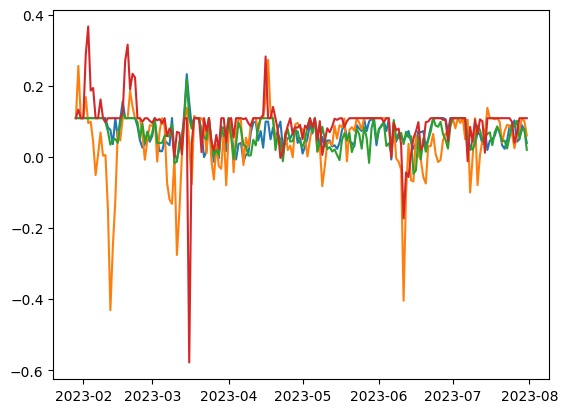

In [ ]:
data = pd.DataFrame(index = transform('BTC').index)

tickers = ['BTC', 'SOL', 'ETH', 'FIL']
for i in tickers:
  data[i] = transform(i)

plt.plot(data)
data.corr() #low correlation for FIL, something to consider working on the strategy

array([[<Axes: title={'center': 'BTC'}>, <Axes: title={'center': 'SOL'}>],
       [<Axes: title={'center': 'ETH'}>, <Axes: title={'center': 'FIL'}>]],
      dtype=object)

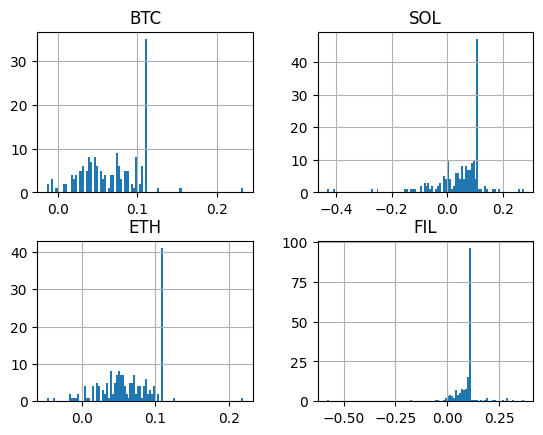

In [ ]:
#Distributions of the asset classes
data.hist(bins=100) #Also test for stationarity
# Lots of rates being 10.75% (implying where premium index = 0)

In [ ]:
# Empirical method of VaR

In [ ]:
stats = data.describe()
stats

,BTC,SOL,ETH,FIL
count,184.000000,184.000000,184.000000,184.000000
mean,0.068279,0.046909,0.065157,0.093271
std,0.037765,0.090677,0.038106,0.074990
min,-0.013333,-0.430650,-0.047293,-0.577638
25%,0.040000,0.005774,0.040560,0.080554
50%,0.070000,0.070845,0.065280,0.109500
75%,0.103333,0.109500,0.098419,0.109500
max,0.233333,0.273370,0.219343,0.367489


count    184.000000
mean       0.073277
std        0.035909
min       -0.007025
25%        0.048132
50%        0.068186
75%        0.101905
max        0.208567
Name: BTCandFIL_portfolio, dtype: float64

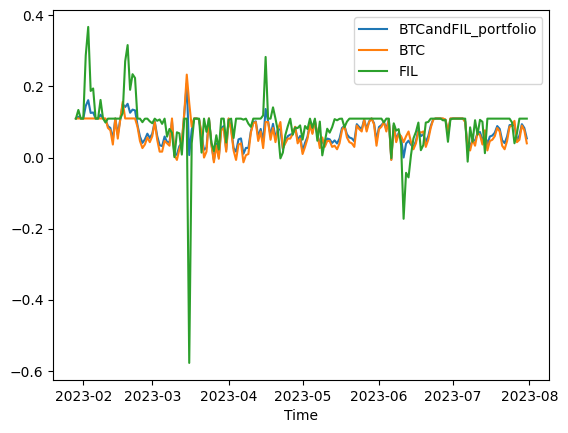

In [ ]:
#BTC_FIL test (good diversification pair)
data['BTCandFIL_portfolio'] = 0.8 * data['BTC'] + 0.2 *data['FIL'] #just an example of ratio that will likely result in lower volatility. Worth taking a look at FIL vs. BTC (or other denominations)!
data[['BTCandFIL_portfolio', 'BTC', 'FIL']].plot()
data['BTCandFIL_portfolio'].describe()

In [ ]:
# Unit root test (strong case of stationarity)
from statsmodels.tsa.stattools import adfuller

def stationarity_test(X):
  X_stationarity = np.array(data[X])
  result = adfuller(X_stationarity)
  print(str(X) + '_test')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

stationarity_test('BTC')
stationarity_test('ETH')
stationarity_test('FIL')
stationarity_test('SOL')

BTC_test
ADF Statistic: -7.670511
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.877
	10%: -2.575
ETH_test
ADF Statistic: -7.839351
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.877
	10%: -2.575
FIL_test
ADF Statistic: -5.222779
p-value: 0.000008
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575
SOL_test
ADF Statistic: -7.138008
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.877
	10%: -2.575


In [ ]:
#Simulation (assume stationarity from previous tests)
import numpy as np

margin_deposit = 0
leverage = 20
minimum_margin_requirement = 0

def open_loss():
  "=No. contract * Absolute Value{min[0, direction of order*(mark price - order price)]}"

  return None

class simulation:
  def __init__(tickers:list, position, leverage, margin):
    simulation.tickers = tickers
    simulation.mean = stats[simulation.tickers].loc['mean']
    simulation.stdev = stats[simulation.tickers].loc['std']
    simulation.position = position
    simulation.leverage = leverage
    simulation.margin = margin

  def process(distribution, days, skewness=None, kurtosis=None):
    process = np.random.default_rng().normal(simulation.mean, simulation.stdev, size=(1,days*3))
    return process

#Maybe another time :(

Return testing with the real prices (omission of margin deposits)



In [ ]:
import yfinance as yf #yahoo finance API

def price(tickers, period):
  return yf.download(tickers=tickers, period=period, interval='1d')

data[['BTC', 'Volume']].corr() #Moderate correlation suggests moderate exposure to volatility. Premium Indicies pretty stable.

,BTC,Volume
BTC,1.000000,0.310683
Volume,0.310683,1.000000


In [ ]:
data[['BTC_price', 'Volume']] = price('BTC-USD', '2y')[['Adj Close', 'Volume']]
data[['FIL_price', 'Volume']] = price('FIL-USD', '2y')[['Adj Close', 'Volume']]

In [ ]:
BTC_FIL = data[['BTC', 'FIL', 'BTC_price', 'FIL_price']]
BTC_FIL['BTC_funding'] = BTC_FIL['BTC_price'] * BTC_FIL['BTC']/360 #given that the rates are annualized
BTC_FIL['FIL_funding'] = 1000* BTC_FIL['FIL_price'] * BTC_FIL['FIL']/360

<Axes: xlabel='Time'>

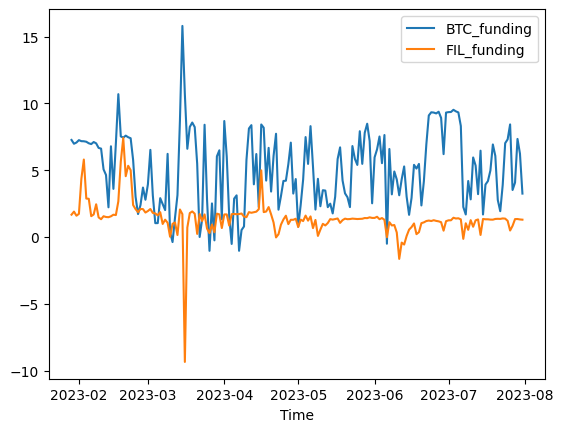

In [ ]:
# Estimated payment amount (in USD)
BTC_paid, FIL_paid = BTC_FIL['BTC_funding'].sum() , BTC_FIL['FIL_funding'].sum()
BTC_FIL[['BTC_funding', 'FIL_funding']].plot() #plot of actual funding under influence of BTC and FIL price flucations


Optimziation with BTC vs. FIL Portfolio